<a href="https://colab.research.google.com/github/elisabethzinck/deep_learning_project/blob/master/Evaluate_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up things

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 163kB 12.7MB/s 
     |████████████████████████████████| 17.7MB 210kB/s 
     |████████████████████████████████| 245kB 40.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 1.4MB 12.3MB/s 
     |████████████████████████████████| 2.9MB 46.2MB/s 
     |████████████████████████████████| 890kB 55.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d24fe98df7e11d5d8668b41c76ca22e0a3483b78641dfc4d4634b98e23af3c6c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Import things to get data to work
from datasets import load_from_disk
import sys
import os

# Load data

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))
train_path = 'drive/My Drive/deep_learning_project/train_small'
val_path = 'drive/My Drive/deep_learning_project/validation_small'

In [6]:
train_data = load_from_disk(train_path)
validation_data = load_from_disk(val_path)

In [7]:
print(train_data[0])
print(validation_data[0])

{'answer': 'york', 'paragraph': ['[P] judi dench', 'born in dorset and later moved to dublin where he was raised he met dench s mother while he was studying medicine at trinity college dublin dench attended the mount school a quaker independent secondary school in york and became a quaker her brothers one of whom was actor jeffery dench were born in tyldesley lancashire her niece emma dench is a roman historian and professor previously at birkbeck university of london and currently at harvard university career in britain dench has developed a reputation as one of the greatest actresses of the post war period primarily through her work in theatre which has been her forte throughout her career she has more than once been named number one in polls for britain s best actor early years'], 'question': ['[Q]', 'Where in England was Dame Judi Dench born?'], 'question_id': 'tc_3'}
{'answer': 'coventry', 'paragraph': ['[P] england', 'camelot excalibur merlin and the knights of the round table su

# Define functions

In [10]:
# Imports required to run functions
import numpy as np
from random import sample
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizerFast, BertModel



def get_top_k(similarity, question_ids, paragraph_ids, k):
    """
    Return the top k documents for based on similarity matrix

    Parameters
    ----------
    similarity : ndarray
        similarity matrix with shape (n_questions, n_paragraphs)
    question_ids : list of str
        List of the question ids
    paragraph_ids : list of str
        List of the paragraph ids (corresponding to the question id that the 
                                   paragraph belongs to)
    k : int
        Number or paragraphs to return

    Returns
    -------
    out : dict
        keys are the question ids, and each element contains list of the ids of the
        k nearest paragraphs
    """
    n_questions = similarity.shape[0]
    idxs = [np.argsort(similarity[row,:])[-k:][::-1] for row in range(n_questions)]
    out = {question_ids[i]:np.array(paragraph_ids)[idxs[i]] for i in range(n_questions)}
    return out

def get_accuracy(top_k):
    """ Returns accuracy. top_k is a dict as returned by get_top_k().  """
    n_correct = [(question in paragraphs) for question, paragraphs in top_k.items()]
    accuracy = sum(n_correct)/len(top_k)*100
    return accuracy


def get_tfidf_similarity(questions, paragraphs):
    """
    Returns a similarity matrix based on the distance in the tf-idf space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    vectorizer = TfidfVectorizer(lowercase = False)
    all_text = questions + paragraphs
    vectorizer.fit(all_text)
    similarity = vectorizer.transform(questions) * vectorizer.transform(paragraphs).T
    return np.array(similarity.todense())

def get_random_accuracy(k_list, n):
    max_k = max(k_list)
    top_k_list = [sample(range(n), max_k) for i in range(n)] # 
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list): 
        n_correct = [(1 in top_k[0:k]) for top_k in top_k_list]
        accs[i] = sum(n_correct)/n*100
    return(accs)

def get_accuracy_vector(k_list, sim, question_ids, paragraph_ids):
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list):
        top_k = get_top_k(sim, question_ids, paragraph_ids, k)
        accs[i] = get_accuracy(top_k)
    return accs



In [28]:
def get_BERT_similarity(questions, paragraphs, tokenizer_name = 'bert-base-uncased', finetuned = False, model_name = 'bert-base-uncased'):
    """
    Returns a similarity matrix based on the distance in the BERT encoded space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    tokenizer_name : string
        What tokenizer to use. Options = ['bert-base-uncased', 'bert-large-uncased']
    finetuned : bool
        Whether to use models that we have finetuned or not
    model_name : string
        Name of model to use. Options = ['bert-base-uncased', 'bert-large-uncased', ']
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    # Define tokenizer 
    tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

    # Define model
    if finetuned:
      folder_path = 'drive/My Drive/deep_learning/BERT/'
      model_path = folder_path + model_name
      model = BertModel.from_pretrained(model_path)
    else:
      model = BertModel.from_pretrained(model_name)
    
    # Tokenize text
    tokens_questions = tokenizer(questions, padding = True)
    tokens_paragraphs = tokenizer(paragraphs, padding = True)

    # Encode text
    E_Q = encoder_BERT(model, tokens_questions)
    E_P = encoder_BERT(model, tokens_paragraphs)

    # Get similarity
    sim = torch.matmul(E_Q, E_P.T).numpy()

    return sim


def encoder_BERT(model, tokenized_text):
    tokens_tensor = torch.tensor(tokenized_text["input_ids"])
    segments_tensor = torch.tensor(tokenized_text["token_type_ids"])
    attention_tensor = torch.tensor(tokenized_text["attention_mask"])
    
    #model = BertModel.from_pretrained('bert-base-uncased')
    
    model.eval()

    with torch.no_grad():
        outputs = model(input_ids=tokens_tensor, attention_mask=attention_tensor, token_type_ids=segments_tensor)
        encoded_layers = outputs[0]
    
    return encoded_layers[:, 0, :]

# Get evaluations

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [36]:
n = 1024
k_list = [i+1 for i in range(int(n/4))]

In [37]:
data = validation_data.select(range(n))

#%% Define inputs
questions_BERT = data['question'][0:n]
question_ids = data['question_id'][0:n]
paragraphs_BERT = data['paragraph'][0:n]
#%%
questions = [entry[0] + ' ' + entry[1] for entry in questions_BERT]
paragraphs = [entry[0] + ' ' + entry[1] for entry in paragraphs_BERT]

In [38]:
tfidf_sim = get_tfidf_similarity(questions, paragraphs)


In [ ]:
# Default base model (no finetuning)
sim_BERT = get_BERT_similarity(questions_BERT, paragraphs_BERT)
#sim_BERT_normalized = StandardScaler().fit_transform(sim_BERT)

In [29]:
# Fine tuned on train model
sim_BERT_finetuned_train = get_BERT_similarity(questions_BERT, paragraphs_BERT, finetuned = True, model_name = '11layer-trained_on_train')

In [18]:
# Default large model (no finetuning) (wait)
#sim_BERT_large = get_BERT_similarity(questions_BERT, paragraphs_BERT, tokenizer_name = 'bert-large-uncased', model_name = 'bert-large-uncased')

In [31]:
#%% Get accuracies for a range of ks
acc_tfidf = get_accuracy_vector(k_list, tfidf_sim, question_ids, question_ids)
acc_bert = get_accuracy_vector(k_list, sim_BERT, question_ids, question_ids)
#acc_bert_normalized = get_accuracy_vector(k_list, sim_BERT_normalized, question_ids, question_ids)
acc_bert_finedtuned_train = get_accuracy_vector(k_list, sim_BERT_finetuned_train, question_ids, question_ids)
acc_random = get_random_accuracy(k_list, n)
#acc_bert_large = DPR.get_accuracy_vector(k_list, sim_BERT_large, question_ids, question_ids)

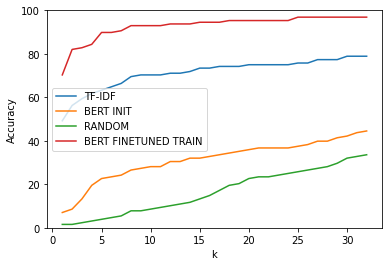

In [35]:
#%%
plt.plot(k_list, acc_tfidf, label = 'tf-idf')
plt.plot(k_list, acc_bert, label = 'BERT - untrained')
plt.plot(k_list, acc_random, label = 'random')
plt.plot(k_list, acc_bert_finedtuned_train, label = 'BERT - finetuned')
#plt.plot(k_list, acc_bert_large, label = 'BERT LARGE INIT')
plt.ylim((0,100))
plt.legend()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#%%
plt.matshow(sim_BERT)
plt.title('BERT similarity matrix')
plt.matshow(tfidf_sim)
plt.title('TF-IDF similarity matrix')
plt.matshow(sim_BERT_normalized)
plt.title('BERT similarity matrix - normalized')

#%%
plt.matshow(sim_BERT_large)

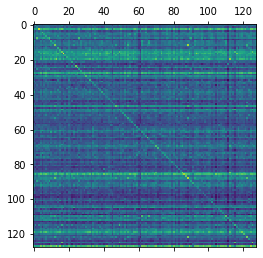

In [30]:
plt.matshow(sim_BERT_finetuned_train)